In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_squared_log_error
import xgboost as xgb
import joblib

# Cargar datos procesados
data = pd.read_csv("../data/processed/data_cleaned_no_outliers.csv")

# Separar características (X) y la variable objetivo (y)
X = data.drop(columns=["PorcentajeCumplimiento"])
y = data["PorcentajeCumplimiento"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Definir el modelo base de XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir la cuadrícula de parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.05],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 0.1, 10],
    'gamma': [0, 0.1, 0.2]
}


In [25]:

# Configurar el GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Mejor conjunto de hiperparámetros
print(f"Mejores hiperparámetros: {grid_search.best_params_}")


Fitting 10 folds for each of 8748 candidates, totalling 87480 fits


C:\Users\geronimo_ramirez\Hernancho\Proyec_predic_cantidades\src\app\WApp\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejores hiperparámetros: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}


In [33]:
# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Recalcular las métricas para el conjunto de prueba
mse = mean_squared_error(y_test, y_test_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
msle = mean_squared_log_error(y_test, y_test_pred)
explained_variance = explained_variance_score(y_test, y_test_pred)

# Imprimir resultados para el conjunto de prueba
print(f"Métricas para el conjunto de prueba:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle}")
print(f"Explained Variance Score: {explained_variance}")

Métricas para el conjunto de prueba:
Mean Squared Error (MSE): 0.0037401547011095652
Root Mean Squared Error (RMSE): 0.061156804209421906
Mean Absolute Error (MAE): 0.046765892488921004
R² Score: 0.14013415302634025
Mean Squared Logarithmic Error (MSLE): 0.0009400370607427095
Explained Variance Score: 0.1402536531319275


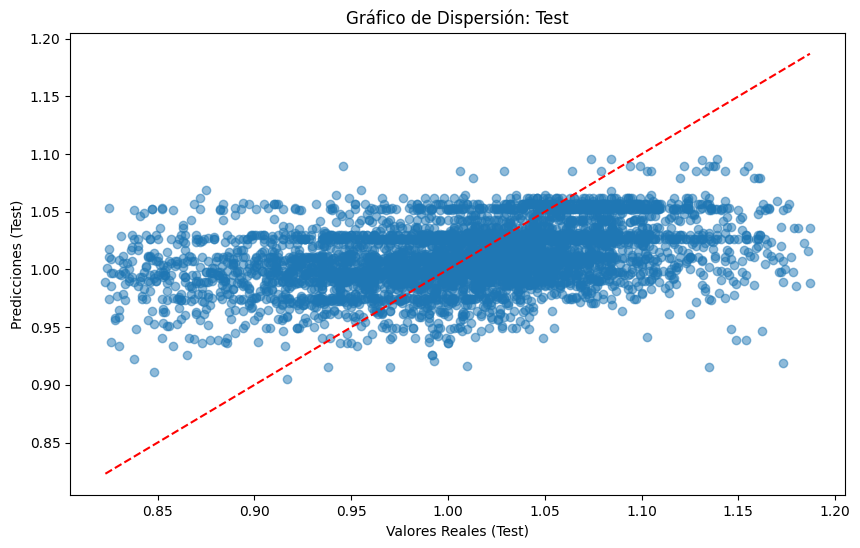

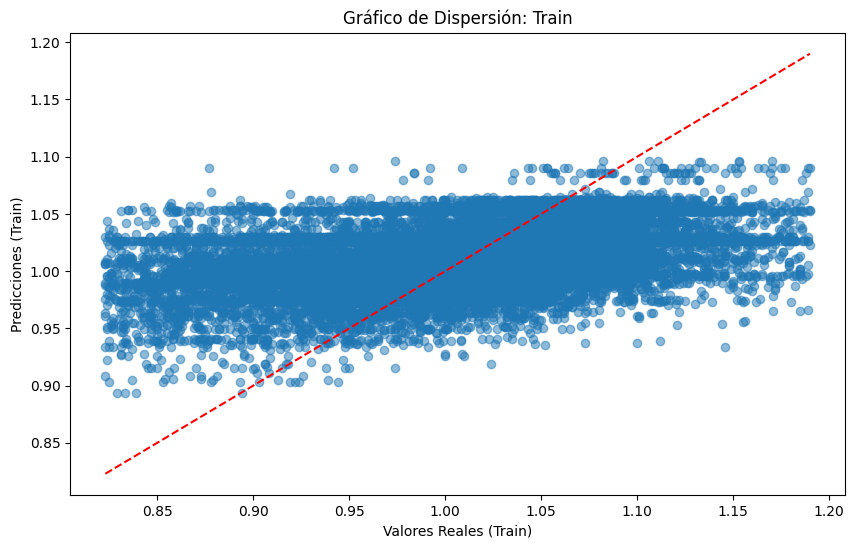

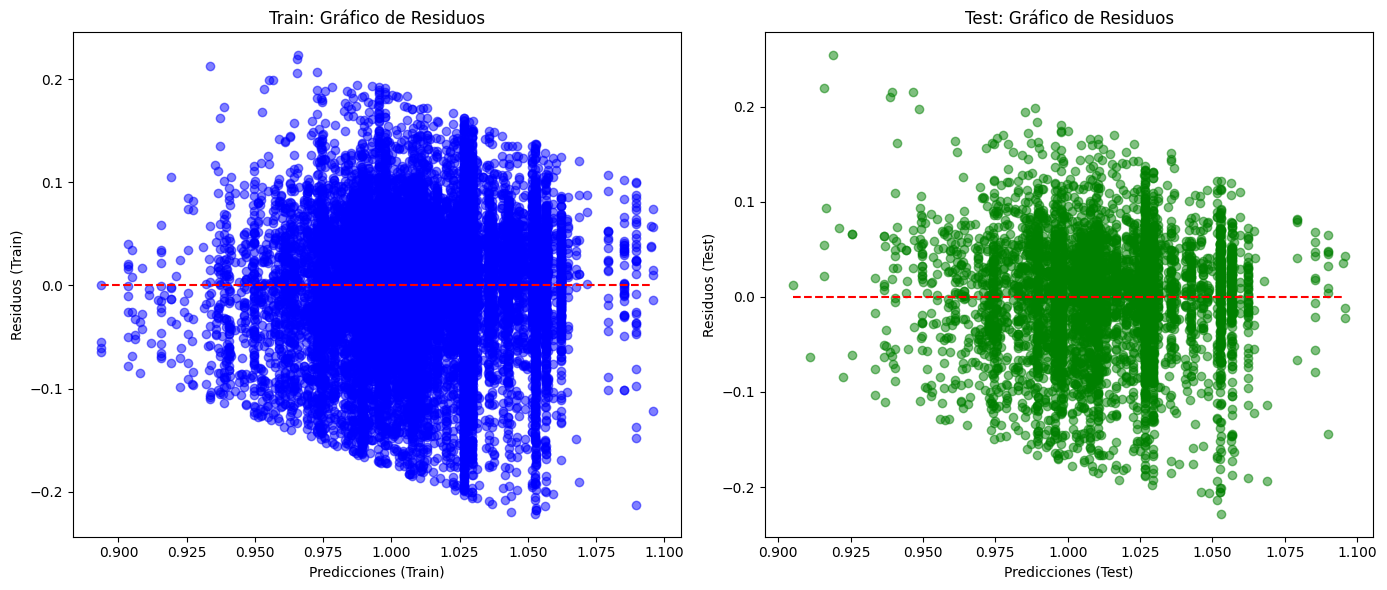

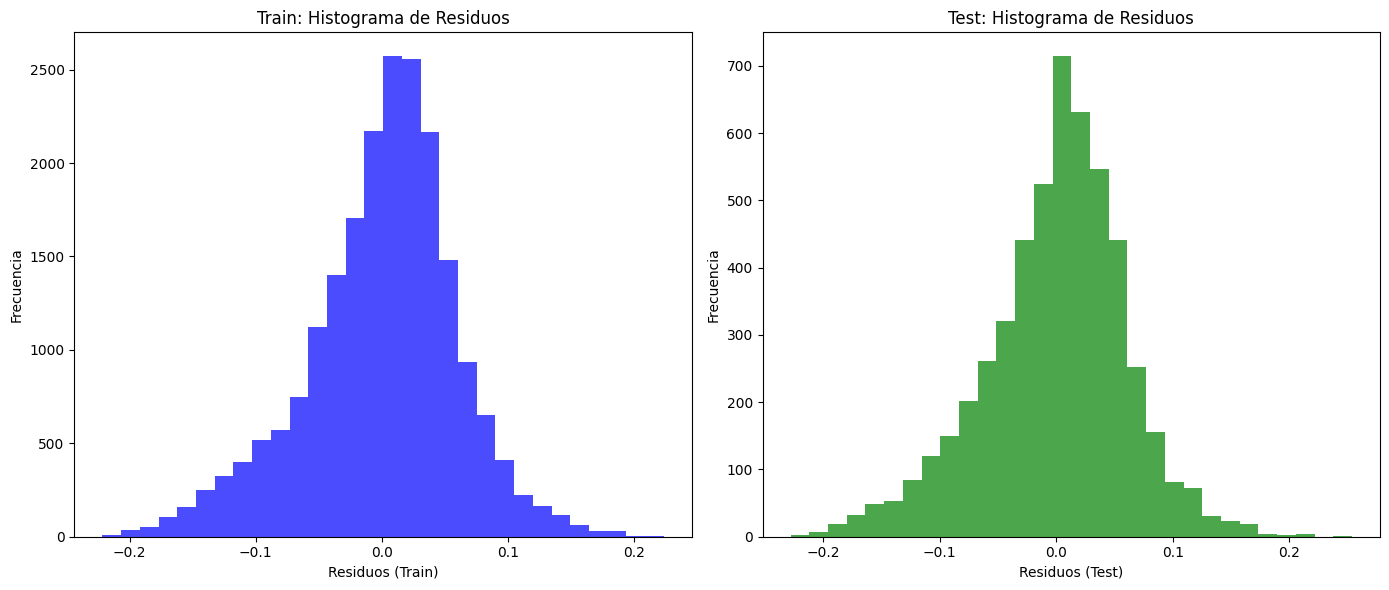

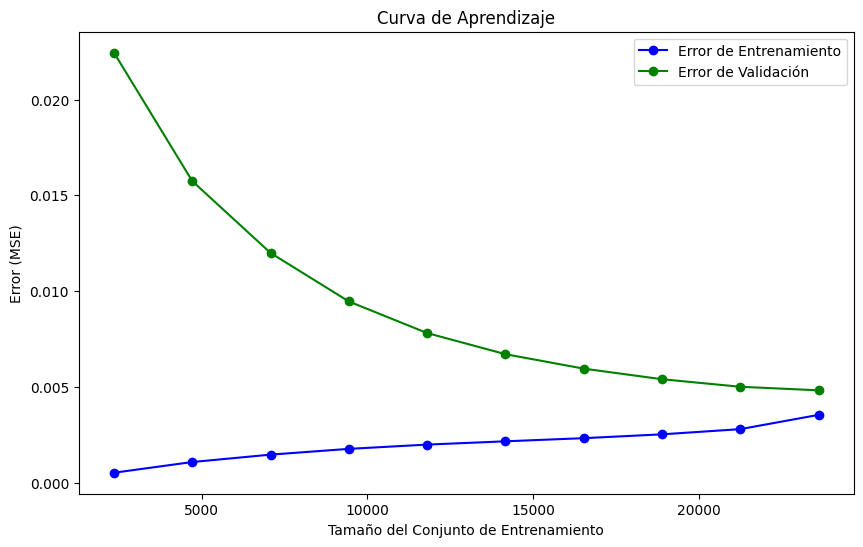

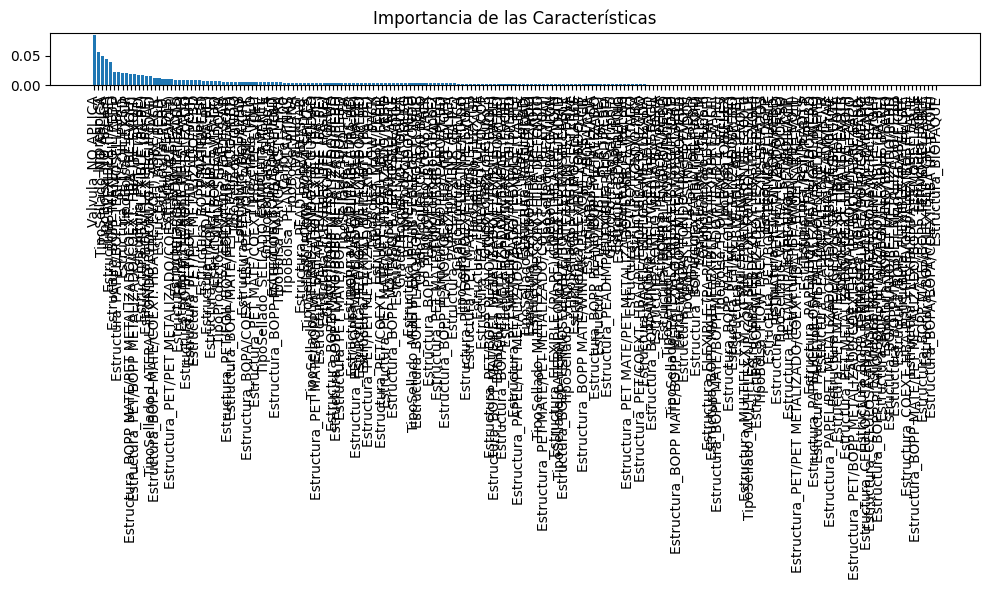

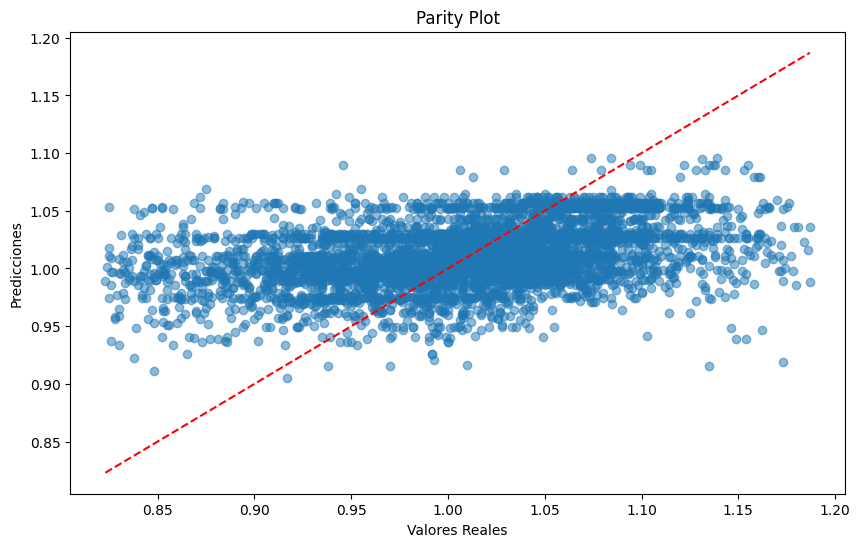

In [32]:
# Gráfico de dispersión para el conjunto de prueba
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valores Reales (Test)")
plt.ylabel("Predicciones (Test)")
plt.title("Gráfico de Dispersión: Test")
plt.show()

# Gráfico de dispersión para el conjunto de entrenamiento
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r')
plt.xlabel("Valores Reales (Train)")
plt.ylabel("Predicciones (Train)")
plt.title("Gráfico de Dispersión: Train")
plt.show()

# Gráfico de residuos (Residual Plot)
plt.figure(figsize=(14, 6))

# Gráfico de residuos para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.5, color='blue')
plt.hlines(y=0, xmin=y_train_pred.min(), xmax=y_train_pred.max(), colors='red', linestyles='--')
plt.xlabel("Predicciones (Train)")
plt.ylabel("Residuos (Train)")
plt.title("Train: Gráfico de Residuos")

# Gráfico de residuos para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.5, color='green')
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='red', linestyles='--')
plt.xlabel("Predicciones (Test)")
plt.ylabel("Residuos (Test)")
plt.title("Test: Gráfico de Residuos")

plt.tight_layout()
plt.show()

# Histograma de residuos
plt.figure(figsize=(14, 6))

# Histograma de residuos para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.hist(y_train - y_train_pred, bins=30, color='blue', alpha=0.7)
plt.xlabel("Residuos (Train)")
plt.ylabel("Frecuencia")
plt.title("Train: Histograma de Residuos")

# Histograma de residuos para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.hist(y_test - y_test_pred, bins=30, color='green', alpha=0.7)
plt.xlabel("Residuos (Test)")
plt.ylabel("Frecuencia")
plt.title("Test: Histograma de Residuos")

plt.tight_layout()
plt.show()

# Curva de aprendizaje (Learning Curve)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Error de Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Error de Validación")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Error (MSE)")
plt.title("Curva de Aprendizaje")
plt.legend(loc="best")
plt.show()

# Importancia de las características (Feature Importance)
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# Parity Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Parity Plot")
plt.show()

In [28]:
joblib.dump(best_model, "../models/optimized_XGB_model.pkl")

['../models/optimized_XGB_model.pkl']